In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# IMPORT
import pandas as pd
import numpy as np
import re
from datetime import datetime

# Project-specific modules
from olist.data import *
from olist.utils import *
from olist.visualisation import *

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins as plugins

# Data Visualisation

In [3]:
data = Olist().get_data()
sellers = data['sellers']
geolocation = data['geolocation']
customers = data['customers']

In [4]:
orders = data['orders']


In [5]:
geo_by_zip_code = geolocation.groupby('geolocation_zip_code_prefix')\
                                .agg({'geolocation_lat':'mean', 'geolocation_lng': 'mean'})

In [6]:
order_items= data['order_items']

In [7]:
order_payments = data['order_payments']

In [8]:
order_reviews = data['order_reviews']

## Sellers

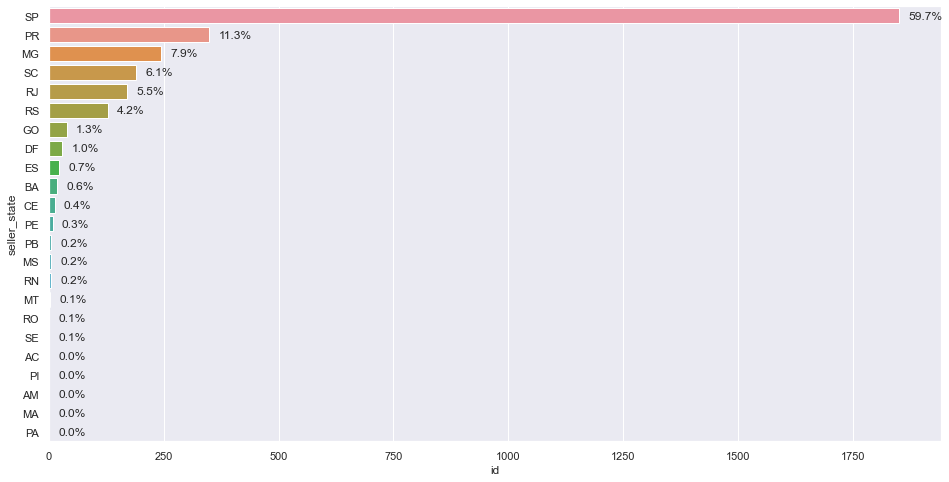

In [12]:
sellers_by_state = count_p_location(sellers, ['seller_state','seller_id'], 'state')
plot_by_state(sellers_by_state);

In [14]:
sellers_by_zip_code= count_p_location(sellers, ['seller_zip_code_prefix','seller_id'], 'zip_code')
plot_cluster(sellers_by_zip_code)

## Customers

<AxesSubplot:xlabel='id', ylabel='customer_state'>

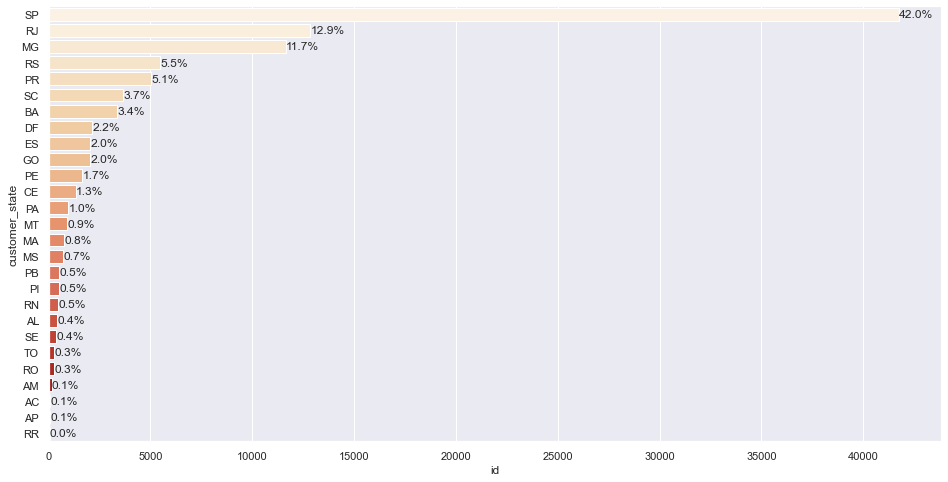

In [15]:
customers_by_state = count_p_location(customers, ['customer_state','customer_id'], 'state')
plot_by_state(customers_by_state, palette= 'OrRd')

In [16]:
customers_by_zip_code = count_p_location(customers, ['customer_zip_code_prefix','customer_id'], 'zip_code')
plot_cluster(customers_by_zip_code)

## Products

In [18]:
product_category_name_translation =data['product_category_name_translation']

In [19]:
products = data['products']
products = products.merge(product_category_name_translation,
                         left_on= 'product_category_name',
                         right_on= 'product_category_name')

In [41]:
product_cat_count = products[['product_id','product_category_name_english']].groupby(
    by= 'product_category_name_english').count()

product_cat_count['Percentage'] = product_cat_count['product_id']/sum(product_cat_count['product_id']) * 100
product_cat_count['Percentage'] = product_cat_count['Percentage'].map('{:,.1f}%'.format)
product_cat_count.sort_values(by= 'Percentage', ascending = False, inplace= True)

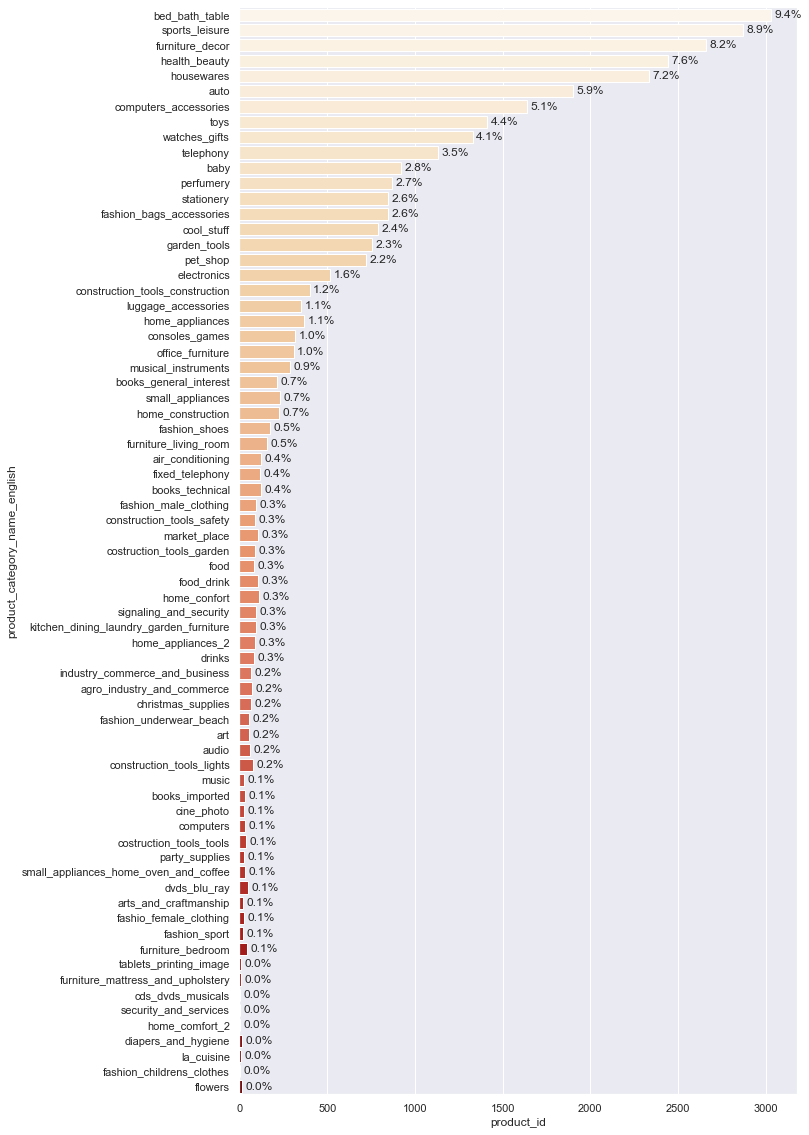

In [50]:
plt.figure(figsize=(10,20)) 
plot_by_state(product_cat_count, palette= 'OrRd');


## Orders

### Orders by Location

In [23]:
orders_geo = orders[['order_id','customer_id']]\
                .merge(customers[['customer_id','customer_zip_code_prefix','customer_state']], 
                        left_on= "customer_id", 
                        right_on='customer_id')\
                .merge(geo_by_zip_code,
                        left_on='customer_zip_code_prefix',
                        right_on='geolocation_zip_code_prefix')


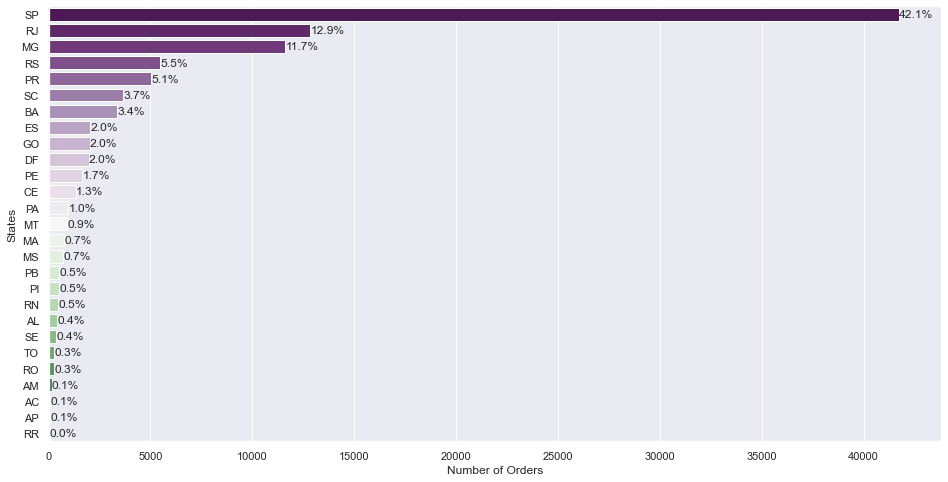

In [24]:
orders_by_state = count_p_location(orders_geo, ['customer_state','order_id'], 'state')
plot1 = plot_by_state(orders_by_state, palette= 'PRGn')
plot1.set_ylabel("States")
plot1.set_xlabel("Number of Orders");

In [25]:
orders_by_zip_code = count_p_location(orders_geo, ['customer_zip_code_prefix','order_id'], 'zip_code')
plot_cluster(orders_by_zip_code)

### Order Values

In [26]:
# Convert string to datetime, then display in YYYYMM format
orders['order_approved_date'] = orders['order_purchase_timestamp'].apply(
    lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y%m'))


In [27]:
orders= orders.merge(order_payments[['order_id','payment_value']],
             left_on= 'order_id',
             right_on= 'order_id')

In [28]:
orders_over_time = orders[['order_id','order_approved_date','payment_value']]\
                    .groupby(by= 'order_approved_date')\
                    .agg({'order_id': 'count', 'payment_value': 'sum'})\
                    .sort_values(by= 'order_approved_date', ascending = True)

In [29]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# convert string to date time, displayed in day of week format
orders['order_day']= pd.to_datetime(orders.order_purchase_timestamp).dt.day_name()

orders_by_weekday = orders[['order_id','order_day','payment_value']]\
                    .groupby(by= 'order_day')\
                    .agg({'order_id': 'count', 'payment_value': 'sum'})\
                    .sort_values('order_day',ascending= True)

orders_by_weekday= orders_by_weekday.reindex(cats)


In [30]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
          'September', 'October', 'November', 'December']

# convert string to date time, displayed in day of week format
orders['order_month']= pd.to_datetime(orders.order_purchase_timestamp).dt.month_name()

# Calculate total number of orders by month of the year and total order value by month of the year
orders_by_month = orders[['order_id','order_month','payment_value']]\
                    .groupby(by= 'order_month')\
                    .agg({'order_id': 'count', 'payment_value': 'sum'})

# Sort data by months, in the order of list months
orders_by_month= orders_by_month.reindex(months)

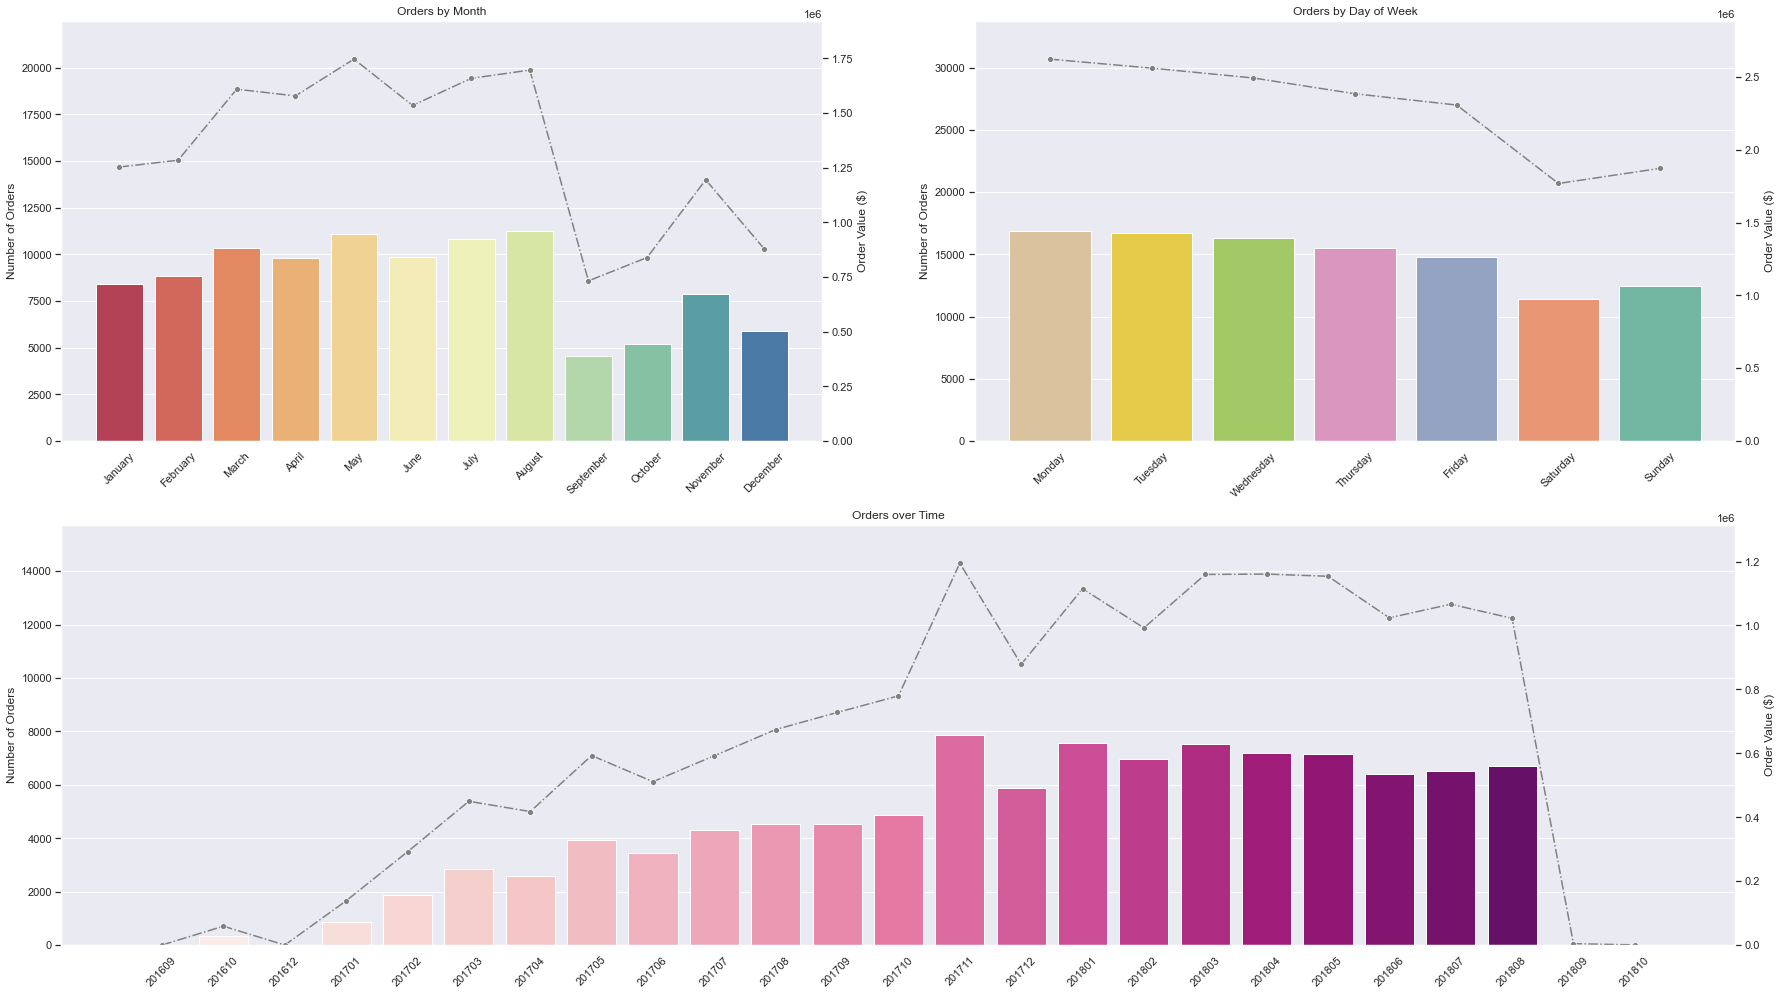

In [31]:
fig = plt.figure(figsize=(30,17)) 

ax1 = plt.subplot(221)
ax1 = double_plot(orders_by_month,'Orders by Month',palette= 'Spectral')

ax2 = plt.subplot(222)
ax2 = double_plot(orders_by_weekday,title= 'Orders by Day of Week', palette= 'Set2_r')


ax3 = plt.subplot(212)
ax3 = double_plot(orders_over_time,title= 'Orders over Time', palette= "RdPu")


## Reviews

- A number of reviews were provided before the order had been delivered and therefore considered inaccurate.
- Legitimate reviews were extracted based on review provided time and delivered time

In [32]:
legit_reviews = order_reviews.merge(orders[['order_id','order_delivered_customer_date']])

In [33]:
legit_reviews['review_date'] = pd.to_datetime(legit_reviews.review_answer_timestamp)
legit_reviews['delivered_date'] = pd.to_datetime(legit_reviews.order_delivered_customer_date)

In [34]:
legit_reviews.query("review_date >= delivered_date", inplace= True)


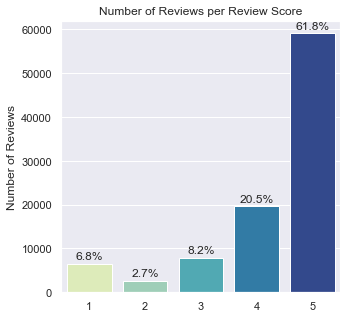

In [35]:
review_count = legit_reviews.groupby('review_score')\
                .agg({'review_id': 'count'})
review_count['Percentage'] = review_count.review_id/sum(review_count.review_id) * 100
review_count['Percentage'] = review_count['Percentage'].map('{:,.1f}%'.format)

# Set figure dimensions
plt.figure(figsize = (5,5))

######################################
# Number of Reviews per Review Score #
######################################
plot2= sns.barplot(x = review_count.index,
                   y = 'review_id',
                   data=review_count,
                   palette= 'YlGnBu')

############################################
# Percentage Annotation on top of Bar Plot #
############################################
x = 0
for patch, percentage in zip(plot2.patches, review_count.iloc[:,1]):   # for each patch/bar
    y = patch.get_height() + 1000                            # offset 1000 from end of bar
    plot2.annotate(percentage,(x,y), horizontalalignment= 'center')
    x += 1
    
# Formating
plot2.set_ylabel('Number of Reviews')
plot2.set(title='Number of Reviews per Review Score', xlabel= None);

In [36]:
negative_reviews = legit_reviews.query("review_score <= 3")

In [37]:
negative_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_delivered_customer_date,review_date,delivered_date
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37,2018-04-12 17:17:53,2018-04-16 00:39:37,2018-04-12 17:17:53
14,9a0abbb668bafb95a6d2b05db43284c4,d7bd0e4afdf94846eb73642b4e3e75c3,3,NaN,NaN,2017-04-30 00:00:00,2017-05-03 00:02:22,2017-04-29 10:19:55,2017-05-03 00:02:22,2017-04-29 10:19:55
18,fdbdb2629a7cde0f66657acc92084e7f,70a752414a13d09cc1f2b437b914b28e,3,NaN,NaN,2017-09-29 00:00:00,2017-10-02 01:12:49,2017-09-28 21:58:54,2017-10-02 01:12:49,2017-09-28 21:58:54
29,2c5e27fc178bde7ac173c9c62c31b070,0ce9a24111d850192a933fcaab6fbad3,1,NaN,Não gostei ! Comprei gato por lebre,2017-12-13 00:00:00,2017-12-16 07:14:07,2017-12-13 00:28:44,2017-12-16 07:14:07,2017-12-13 00:28:44
44,ab3056e4fb5a36df4b58c1746e4a6b8f,aad1dcbe4c9fe2e3486e5e04c6649097,2,NaN,NaN,2018-05-13 00:00:00,2018-05-14 16:29:15,2018-05-12 15:04:50,2018-05-14 16:29:15,2018-05-12 15:04:50
...,...,...,...,...,...,...,...,...,...,...
103650,2ee221b28e5b6fceffac59487ed39348,f2d12dd37eaef72ed7b1186b2edefbcd,2,Foto enganosa,Foto muito diferente principalmente a graninha...,2018-03-28 00:00:00,2018-05-25 01:23:26,2018-03-27 13:48:59,2018-05-25 01:23:26,2018-03-27 13:48:59
103653,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,NaN,Tive um problema na entrega em que o correio c...,2018-02-21 00:00:00,2018-02-23 11:43:12,2018-02-20 01:15:50,2018-02-23 11:43:12,2018-02-20 01:15:50
103668,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,NaN,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06,2018-05-18 17:12:51,2018-05-20 21:51:06,2018-05-18 17:12:51
103669,115d72425fc59eec9a2e9d7594c6d93d,acd45245723df7cb52772a34416b41b1,3,NaN,NaN,2018-05-08 00:00:00,2018-05-10 14:37:03,2018-05-07 16:48:43,2018-05-10 14:37:03,2018-05-07 16:48:43
